# Développez un chatbot pour réserver des vacances

## Librairies

In [206]:
import requests
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import re
import json
import pickle
from sklearn.model_selection import train_test_split
from dotenv import load_dotenv

## Settings

In [2]:
plt.style.use("dark_background")

## Téléchargement des données

In [4]:
data_path = "./data/"
remote_url = "https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/AI+Engineer/Project+10%C2%A0-+D%C3%A9veloppez+un+chatbot+pour+r%C3%A9server+des+vacances/frames.zip"
local_file = data_path + "frames.zip"

In [15]:
# création du dossier ./data/
# qui contiendra les données
if re.sub('[^A-Za-z0-9]+', '', data_path) not in os.listdir("."):
    print("Création du dossier ", data_path)
    os.mkdir(data_path)
else:
    print("Le dossier {} existe déjà".format(data_path))
os.listdir(".")

Le dossier ./data/ existe déjà


['.ipynb_checkpoints', 'data', 'ocp10', 'Untitled.ipynb']

In [17]:
# téléchargement du fichier Zip contenant les données
if not os.path.exists(local_file):
    print("Téléchargement de ", remote_url)
    data = requests.get(remote_url)
    with open(local_file, 'wb')as file:
        file.write(data.content)
    # décompression des fichiers
    print("Décompression de ", local_file)
    with zipfile.ZipFile(local_file, 'r') as zip_ref:
        zip_ref.extractall(data_path)
else:
    print(local_file + " existe déjà")

Téléchargement de  https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/AI+Engineer/Project+10%C2%A0-+D%C3%A9veloppez+un+chatbot+pour+r%C3%A9server+des+vacances/frames.zip
Décompression de  ./data/frames.zip


In [18]:
os.listdir(data_path)

['frames.json', 'frames.zip', 'LICENSE.pdf']

## Exploration des données

In [19]:
data = pd.read_json(data_path  + "frames.json")
data.head()

,user_id,turns,wizard_id,id,labels
0,U22HTHYNP,[{'text': 'I'd like to book a trip to Atlantis...,U21DKG18C,e2c0fc6c-2134-4891-8353-ef16d8412c9a,"{'userSurveyRating': 4.0, 'wizardSurveyTaskSuc..."
1,U21E41CQP,"[{'text': 'Hello, I am looking to book a vacat...",U21DMV0KA,4a3bfa39-2c22-42c8-8694-32b4e34415e9,"{'userSurveyRating': 3.0, 'wizardSurveyTaskSuc..."
2,U21RP4FCY,[{'text': 'Hello there i am looking to go on a...,U21E0179B,6e67ed28-e94c-4fab-96b6-68569a92682f,"{'userSurveyRating': 2.0, 'wizardSurveyTaskSuc..."
3,U22HTHYNP,[{'text': 'Hi I'd like to go to Caprica from B...,U21DKG18C,5ae76e50-5b48-4166-9f6d-67aaabd7bcaa,"{'userSurveyRating': 5.0, 'wizardSurveyTaskSuc..."
4,U21E41CQP,"[{'text': 'Hello, I am looking to book a trip ...",U21DMV0KA,24603086-bb53-431e-a0d8-1dcc63518ba9,"{'userSurveyRating': 5.0, 'wizardSurveyTaskSuc..."


In [29]:
data.shape

(1369, 5)

- ```id``` est l'identifiant unique du dialogue
- ```user_id``` est l'identifiant unique de l'utilisateur
- ```wizard_id``` est l'identifiant unique du bot prenant part au dialogue
- ```turns```  est un *json* qui contient la conversation et différents éléments que nous expliciterons plus tard
- ```labels``` est un json qui contient deux clés : 
    - ```userSurveyRating``` : Une valeur qui représente la satisfaction de l'utilisateur vis-à-vis du service du chatbot, allant de 1 - insatisfaction totale à 5 - satisfaction totale.
    - ```wizardSurveyTaskSuccessful``` : Un booléen qui est vrai si le chatbot pense à la fin du dialogue que l'objectif de l'utilisateur a été atteint.

La colonne ```turns``` contient les conversations sous forme de json. Regardons ce que contient celui de la première ligne:

In [28]:
print(json.dumps(data["turns"][0], indent=2))

[
  {
    "text": "I'd like to book a trip to Atlantis from Caprica on Saturday, August 13, 2016 for 8 adults. I have a tight budget of 1700.",
    "labels": {
      "acts": [
        {
          "args": [
            {
              "val": "book",
              "key": "intent"
            }
          ],
          "name": "inform"
        },
        {
          "args": [
            {
              "val": "Atlantis",
              "key": "dst_city"
            },
            {
              "val": "Caprica",
              "key": "or_city"
            },
            {
              "val": "Saturday, August 13, 2016",
              "key": "str_date"
            },
            {
              "val": "8",
              "key": "n_adults"
            },
            {
              "val": "1700",
              "key": "budget"
            }
          ],
          "name": "inform"
        }
      ],
      "acts_without_refs": [
        {
          "args": [
            {
              "val": "b

In [43]:
for i in range(len(data["turns"][0])):
    print(data["turns"][0][i].keys())

dict_keys(['text', 'labels', 'author', 'timestamp'])
dict_keys(['db', 'text', 'labels', 'author', 'timestamp'])
dict_keys(['text', 'labels', 'author', 'timestamp'])
dict_keys(['db', 'text', 'labels', 'author', 'timestamp'])
dict_keys(['text', 'labels', 'author', 'timestamp'])
dict_keys(['db', 'text', 'labels', 'author', 'timestamp'])
dict_keys(['text', 'labels', 'author', 'timestamp'])


In [48]:
def print_conversation(index):
    for i in range(len(data["turns"][index])):
        author = data["turns"][index][i]["author"]
        text = data["turns"][index][i]["text"]
        print("- {} : {}".format(author, text))

print_conversation(51)

- user : Hi going on vacation with my Family can you help me book a vacation?
- wizard : Where would you like to go?
- user : We want to go to Atlanta
- wizard : How many people will you be?
- user : in total the party will be 7 kids and 5 adults
- wizard : Can you please tell me where you will be departing from?
- user : We’re in Santa cruz!
- wizard : I am sorry but I have nothing available to Atlanta at the moment. However, I have packages available to Rosario and Buenos Aires.
- user : Rosario seems like a nice place? what packages do we have there?
- wizard : Well, can you please tell me your dates and the number of days you would like to spend there?
- user : we have around $34300, depending on how good the deal is were willing to change it. At the moment we can go whenever
- wizard : I have the Opportunity Suites available from August 27th to Aug 30th. You would all fly business class. The deal also includes Free wifi and free breakfast.
- user : what options are there for Bueno

Penchons-nous à présent sur les entités extraites dans les conversations. Nous ne nous intéresserons qu'aux entités suivantes : 
- **Ville de départ** (```or_city```)
- **Ville d'arrivée** (```dst_city```)
- **Date de départ** (```str_date```)
- **Date de fin** (```end_date```)
- **Budget** (```budget```)

## Conversion des données pour LUIS

In [110]:
ls_entities = [
    "or_city",
    "dst_city",
    "str_date",
    "end_date",
    "budget"
]

def get_turn_entities(data, index, ls_entities):
    luis_data = []
    for conversation in data["turns"][index]:
        json_part = {}
        txt = conversation["text"].lower()
        json_part["text"] = txt
        json_part["intentName"] = "BookFlight"
        # Nous n'utiliserons que ce qu'ont
        # écrit les utilisateurs
        if conversation["author"] == "user":
            for act in conversation["labels"]["acts"]:
                entities = []
                for arg in act["args"]:
                    if arg["key"] in ls_entities:
                        entity = {}
                        key = arg["key"].lower()
                        if "val" in arg.keys():
                            val = arg["val"].lower()
                            if val != "-1":
                                startCharIndex = txt.index(val)
                                endCharIndex = startCharIndex + len(val)
                                entity["entityName"] = key
                                entity["startCharIndex"] = startCharIndex
                                entity["endCharIndex"] = endCharIndex
                                entities.append(entity)
                json_part["entityLabels"] = entities
                
        if (len(json_part)>0):
            if "entityLabels" in json_part.keys():
                if len(json_part["entityLabels"])>0:
                    luis_data.append(json_part)
    return luis_data


get_turn_entities(data, 0, ls_entities)

[{'text': "i'd like to book a trip to atlantis from caprica on saturday, august 13, 2016 for 8 adults. i have a tight budget of 1700.",
  'intentName': 'BookFlight',
  'entityLabels': [{'entityName': 'dst_city',
    'startCharIndex': 27,
    'endCharIndex': 35},
   {'entityName': 'or_city', 'startCharIndex': 41, 'endCharIndex': 48},
   {'entityName': 'str_date', 'startCharIndex': 52, 'endCharIndex': 77},
   {'entityName': 'budget', 'startCharIndex': 117, 'endCharIndex': 121}]},
 {'text': 'yes, how about going to neverland from caprica on august 13, 2016 for 5 adults. for this trip, my budget would be 1900.',
  'intentName': 'BookFlight',
  'entityLabels': [{'entityName': 'dst_city',
    'startCharIndex': 24,
    'endCharIndex': 33},
   {'entityName': 'budget', 'startCharIndex': 114, 'endCharIndex': 118}]}]

In [113]:
def convert_data(data, ls_entities):
    luis_data = []
    for i in range(data.shape[0]):
        json_part = get_turn_entities(data, i, ls_entities)
        if len(json_part)>0:
            for j in range(len(json_part)):
                luis_data.append(json_part[j])
    return luis_data

luis_data = convert_data(data, ls_entities)
print(luis_data[:5])

[{'text': "i'd like to book a trip to atlantis from caprica on saturday, august 13, 2016 for 8 adults. i have a tight budget of 1700.", 'intentName': 'BookFlight', 'entityLabels': [{'entityName': 'dst_city', 'startCharIndex': 27, 'endCharIndex': 35}, {'entityName': 'or_city', 'startCharIndex': 41, 'endCharIndex': 48}, {'entityName': 'str_date', 'startCharIndex': 52, 'endCharIndex': 77}, {'entityName': 'budget', 'startCharIndex': 117, 'endCharIndex': 121}]}, {'text': 'yes, how about going to neverland from caprica on august 13, 2016 for 5 adults. for this trip, my budget would be 1900.', 'intentName': 'BookFlight', 'entityLabels': [{'entityName': 'dst_city', 'startCharIndex': 24, 'endCharIndex': 33}, {'entityName': 'budget', 'startCharIndex': 114, 'endCharIndex': 118}]}, {'text': 'what about a trip from gotham city to neverland for the same budget?', 'intentName': 'BookFlight', 'entityLabels': [{'entityName': 'dst_city', 'startCharIndex': 38, 'endCharIndex': 47}, {'entityName': 'or_city

In [178]:
print(json.dumps(luis_data[4], indent=2))

{
  "text": "you know what, i'd like to try and visit neverland",
  "intentName": "BookFlight",
  "entityLabels": [
    {
      "entityName": "dst_city",
      "startCharIndex": 41,
      "endCharIndex": 50
    }
  ]
}


In [179]:
train_data, test_data = train_test_split(
    luis_data, 
    test_size=0.2, 
    shuffle=True
)

In [180]:
print("Taille du jeu d'entraînement : ", len(train_data))
print("Taille du jeu de test : ", len(test_data))

Taille du jeu d'entraînement :  3308
Taille du jeu de test :  827


## Création de l'application LUIS

In [167]:
from azure.cognitiveservices.language.luis.authoring import LUISAuthoringClient
from azure.cognitiveservices.language.luis.authoring.models import ApplicationCreateObject
from azure.cognitiveservices.language.luis.runtime import LUISRuntimeClient
from msrest.authentication import CognitiveServicesCredentials
from functools import reduce
import json, time, uuid

Récupérons les variables qui contiendront les clés de création et les noms des ressources:

In [211]:
load_dotenv()
authoringKey = os.getenv("authoringKey")
authoringEndpoint = os.getenv("authoringEndpoint")
predictionKey = os.getenv("predictionKey")
predictionEndpoint = os.getenv("predictionEndpoint")

Créons des variables qui contiendront le nom de l'application, la version et le nom de l'intention:

In [169]:
# We use a UUID to avoid name collisions.
appName = "FlyMeBot-" + str(uuid.uuid4())
versionId = "0.1"
intentName = "BookFlight"

Créons un objet **CognitiveServiceCredentials** avec notre clé et utilisons-le avec notre point de terminaison pour créer un objet **LuisAuthoringClient**

In [171]:
client = LUISAuthoringClient(
    authoringEndpoint, 
    CognitiveServicesCredentials(authoringKey)
)

Une application LUIS contient le modèle de traitement du langage naturel (NLP), y compris les intentions, les entités et les exemples d'énoncés.

Créons la méthode d'ajout d'un objet AppsOperation pour créer l'application. Le nom et la culture linguistique sont des propriétés obligatoires.

In [172]:
# define app basics
appDefinition = ApplicationCreateObject (
    name=appName, 
    initial_version_id=versionId, 
    culture='en-us'
)

# create app
app_id = client.apps.add(appDefinition)

# get app id - necessary for all other changes
print("Created LUIS app with ID {}".format(app_id))

Created LUIS app with ID 74f68d80-8b03-45b0-bc98-a256adb35ef5


### Création d'une intention pour l'application

L'objet principal dans le modèle d'une application LUIS est l'intention. L'intention s'aligne sur un groupe d'*intentions* d'énoncé de l'utilisateur . Un utilisateur peut poser une question ou faire une déclaration à la recherche d'une réponse particulière d'un bot (ou d'une autre application cliente). Des exemples d'intentions sont la réservation d'un vol, la demande sur la météo dans une ville de destination et la demande d'informations de contact pour le service client...

Utilisons la méthode model.add_intent avec le nom de l'intention unique, puis transmettons l'ID d'application, l'ID de version et le nouveau nom d'intention.

La ```intentNamevaleur``` est codée en dur dans ```BookFlightIntent``` en tant que variables de la section "Créer des variables pour l'application" .

In [173]:
intent_id = client.model.add_intent(app_id, versionId, intentName)
print(f"{intentName} intent created with id {intent_id}")

BookFlight intent created with id 4bb70a60-8e3d-49c6-bc12-c99d7563b125


### Création des entités pour l'application

Bien que les entités ne soient pas obligatoires, elles se trouvent dans la plupart des applications. L'entité extrait les informations de l'énoncé de l'utilisateur, nécessaires pour réaliser l'intention de l'utilisateur. Il existe plusieurs types d' entités prédéfinies et personnalisées, chacune avec ses propres modèles d'objet de transformation de données (DTO). Les entités prédéfinies courantes à ajouter à une application incluent number , datetimeV2 , geographicV2 , ordinal .

Il est important de savoir que les entités ne sont pas marquées d'une intention. Elles peuvent s'appliquer et s'appliquent généralement à de nombreuses intentions. Seuls les exemples d'énoncés utilisateur sont marqués pour une intention unique spécifique.

Les méthodes de création d'entités font partie de la classe ModelOperations . Chaque type d'entité possède son propre modèle d'objet de transformation de données (DTO).

Le code de création d'entité crée une entité d'apprentissage automatique avec des sous-entités et des fonctionnalités appliquées aux sous-entités ```Quantity```.

In [174]:
entities = [
    'or_city', 
    'dst_city', 
    'str_date', 
    'end_date', 
    'budget'
]
prebuilt_entities= [
    'geographyV2', 
    'datetimeV2', 
    'number'
]
entities_map = {
    'or_city': 'geographyV2', 
    'dst_city': 'geographyV2', 
    'str_date': 'datetimeV2', 
    'end_date': 'datetimeV2', 
    'budget': 'number'
}

In [175]:
# Add prebuilt entities
for prebuilt in prebuilt_entities:
    prebuilt_entity_id = client.model.add_prebuilt(
        app_id=app_id,
        version_id=versionId,
        prebuilt_extractor_names=[prebuilt],
    )
    print(f"{prebuilt} prebuilt entity created with id {prebuilt_entity_id}")

geographyV2 prebuilt entity created with id [<azure.cognitiveservices.language.luis.authoring.models._models_py3.PrebuiltEntityExtractor object at 0x0000016C8BE275E0>]
datetimeV2 prebuilt entity created with id [<azure.cognitiveservices.language.luis.authoring.models._models_py3.PrebuiltEntityExtractor object at 0x0000016C8BE39330>]
number prebuilt entity created with id [<azure.cognitiveservices.language.luis.authoring.models._models_py3.PrebuiltEntityExtractor object at 0x0000016C8BE26290>]


In [176]:
# Create entities and entity features into the model
for entity in entities:
    entity_id = client.model.add_entity(
        app_id=app_id,
        version_id=versionId, 
        name=entity
    )
    print(f"{entity} entity created with id {entity_id}")

    feature_id = client.features.add_entity_feature(
        app_id=app_id,
        version_id=versionId,
        entity_id=entity_id,
        feature_relation_create_object={
            "model_name": entities_map[entity],
        },
    )
    print(f"{entities_map[entity]} feature created with id {feature_id} in entity {entity}")

or_city entity created with id b7dc4a68-ad66-41c2-a6a1-72a3521ca526
geographyV2 feature created with id {'additional_properties': {}, 'code': 'Success', 'message': 'Operation Successful'} in entity or_city
dst_city entity created with id 945df98c-8131-4eb9-bd11-64bafd9bebf5
geographyV2 feature created with id {'additional_properties': {}, 'code': 'Success', 'message': 'Operation Successful'} in entity dst_city
str_date entity created with id 1f442728-528e-48b5-be78-3f8b9ba1b3d1
datetimeV2 feature created with id {'additional_properties': {}, 'code': 'Success', 'message': 'Operation Successful'} in entity str_date
end_date entity created with id 763a683b-c201-4ba1-8822-dd696c0916c6
datetimeV2 feature created with id {'additional_properties': {}, 'code': 'Success', 'message': 'Operation Successful'} in entity end_date
budget entity created with id 92e27611-3132-4264-94d1-aa82a3b5220e
number feature created with id {'additional_properties': {}, 'code': 'Success', 'message': 'Operation Suc

### Entrainement du modèle

Il est à présent temps d'entraîner notre cher LUIS à comprendre tout ce qui sera nécessaire à la réservation de nos voyages

In [181]:
# Commençons par créer des batch
for i in range(0, len(train_data), 100):
    j = i + 100
    if j > len(train_data):
        j = len(train_data)

    client.examples.batch(
        app_id,
        versionId,
        train_data[i:j]
    )

In [183]:
# Puis entraînons le modèle
print("Début de l'entraînement...")
print("Si vous voulez aller chercher un café, c'est maintenant")

client.train.train_version(app_id, versionId)
waiting = True

while waiting:
    info = client.train.get_status(app_id, versionId)

    # get_status retourne une liste de status d'entraînements, 
    # un pour chaque modèle. Nous les parcourons pour s'assurer que tout est fait.
    waiting = any(map(lambda x: 'Queued' == x.details.status or 'InProgress' == x.details.status, info))
    if waiting:
        print ("Petite pause de 10 secondes...")
        time.sleep(10)
    else: 
        print("Notre cher LUIS est entraîné :) !")
        waiting = False

Début de l'entraînement...
Si vous voulez aller chercher un café, c'est maintenant
Petite pause de 10 secondes...
Petite pause de 10 secondes...
Petite pause de 10 secondes...
Petite pause de 10 secondes...
Petite pause de 10 secondes...
Petite pause de 10 secondes...
Petite pause de 10 secondes...
Petite pause de 10 secondes...
Petite pause de 10 secondes...
Petite pause de 10 secondes...
Petite pause de 10 secondes...
Petite pause de 10 secondes...
Petite pause de 10 secondes...
Petite pause de 10 secondes...
Petite pause de 10 secondes...
Petite pause de 10 secondes...
Petite pause de 10 secondes...
Petite pause de 10 secondes...
Petite pause de 10 secondes...
Petite pause de 10 secondes...
Petite pause de 10 secondes...
Petite pause de 10 secondes...
Notre cher LUIS est entraîné :) !


### Publication de l'application

In [184]:
# Publication de l'app
print("Début de la publication de l'app...")

client.apps.update_settings(
    app_id, 
    is_public=True
)
publish_result = client.apps.publish(
    app_id, 
    versionId, 
    is_staging=False
)

endpoint = publish_result.endpoint_url + \
            "?subscription-key=" + authoringKey + "&q="

print("L'app est publiée.")
print("Merci de votre attention, vous pouvez maintenant reprendre une activité normale.")

Début de la publication de l'app...
L'app est publiée.
Merci de votre attention, vous pouvez maintenant reprendre une activité normale.


## Test de l'application

In [185]:
runtimeCredentials = CognitiveServicesCredentials(authoringKey)
clientRuntime = LUISRuntimeClient(
    endpoint='https://westeurope.api.cognitive.microsoft.com', 
    credentials=runtimeCredentials
)

In [187]:
request = { 
    "query" : "I want to go to Berlin next monday with 500€" 
}

predictionResponse = clientRuntime.prediction.get_slot_prediction(
    app_id=app_id, 
    slot_name="Production", 
    prediction_request=request
)

print("Top intent: {}".format(predictionResponse.prediction.top_intent))
print("Intents: ")

for intent in predictionResponse.prediction.intents:
    print("\t{}".format(intent))
print("Entities: {}".format(json.dumps(predictionResponse.prediction.entities, indent=2)))

Top intent: BookFlight
Intents: 
	BookFlight
Entities: {
  "dst_city": [
    "Berlin"
  ],
  "geographyV2": [
    {
      "value": "Berlin",
      "type": "city"
    }
  ],
  "datetimeV2": [
    {
      "type": "date",
      "values": [
        {
          "timex": "2022-10-03",
          "resolution": [
            {
              "value": "2022-10-03"
            }
          ]
        }
      ]
    }
  ],
  "number": [
    500
  ],
  "budget": [
    "500\u20ac"
  ]
}


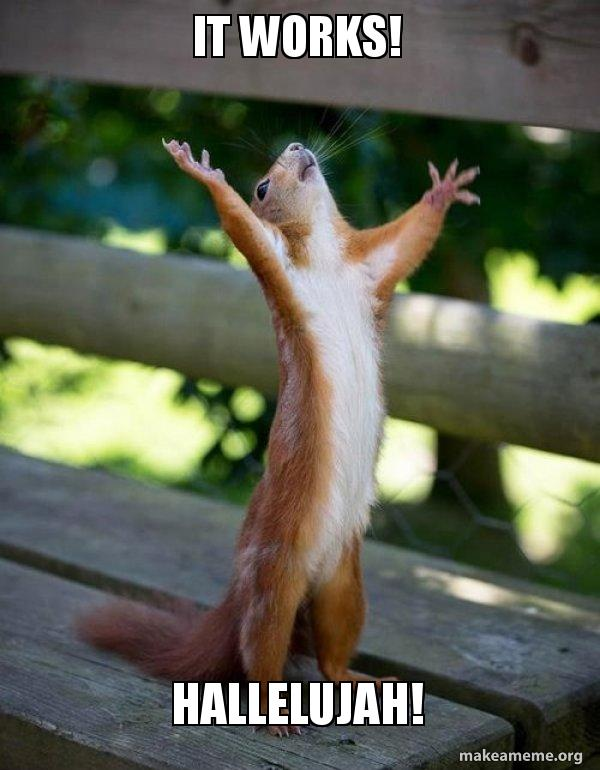

### Evaluation du modèle

In [200]:
def predict(clientRuntime, app_id, query):
    request = { "query" : query }
    response = clientRuntime.prediction.get_slot_prediction(
        app_id, 
        "Production", 
        request
    )
    entities = response.prediction.entities
    entities = {k:v[0] for k, v in entities.items()}
    return entities

def format_true_data(data):
    y_true = {}
    text = data['text']
    for entity in data['entityLabels']:
        y_true[entity['entityName']] = text[entity['startCharIndex']:entity['endCharIndex']]
    return y_true

def accuracy_score(y_pred, y_true):
    score = 0
    for k, v in y_true.items():
        if k in y_pred:
            if v == y_pred[k]:
                score += 1
            elif v in y_pred[k]:
                score += 0.5
    accuracy = score * 100 /len(y_true)
    return accuracy

def evaluate(test_data):
    scores = []
    for data in test_data:
        y_pred = predict(
            clientRuntime, 
            app_id, data['text']
        )
        y_true = format_true_data(data)
        scores.append(accuracy_score(y_pred, y_true))
    mean_score = sum(scores) / len(scores)
    return scores, mean_score

In [201]:
scores, mean_score = evaluate(test_data[0:100])

In [204]:
print("Le score moyen est de {}% sur 100 échantillons de notre jeu de test, entre les prédictions du modèle et les vrais labels".format(mean_score))

Le score moyen est de 69.175% sur 100 échantillons de notre jeu de test, entre les prédictions du modèle et les vrais labels
